In [18]:
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiLineString
import pyvista as pv
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd

# Desactiva todos los warnings
warnings.filterwarnings("ignore")

In [14]:
# Cargar las curvas de nivel desde un Shapefile
curvas_nivel_gdf = gpd.read_file('data/Maqueta')
curvas_nivel_gdf.rename(columns={'CONTOUR': 'elevation'}, inplace=True)

edificaciones_gdf = gpd.read_file('./data/construcciones_maqueta')
edificaciones_gdf.dropna(subset=['geometry'], inplace=True)

In [20]:
def obtener_limites_geodf(geodf):
    """
    Calcula los límites espaciales (x_min, x_max, y_min, y_max) de un GeoDataFrame.

    :param geodf: GeoDataFrame con geometrías LineString.
    :return: Tupla con los valores (x_min, x_max, y_min, y_max).
    """
    x_min, x_max, y_min, y_max = float('inf'), float('-inf'), float('inf'), float('-inf')

    for linea in geodf.geometry:
        bounds = linea.bounds
        x_min, y_min = min(x_min, bounds[0]), min(y_min, bounds[1])
        x_max, y_max = max(x_max, bounds[2]), max(y_max, bounds[3])

    return x_min, x_max, y_min, y_max

def limites_a_puntos_geodf(x_min, x_max, y_min, y_max):
    """
    Convierte los límites en un GeoDataFrame con los cuatro puntos de esquina.

    :param x_min: Límite mínimo en el eje X.
    :param x_max: Límite máximo en el eje X.
    :param y_min: Límite mínimo en el eje Y.
    :param y_max: Límite máximo en el eje Y.
    :return: GeoDataFrame con los cuatro puntos de esquina.
    """
    # Crear los puntos de esquina
    puntos = [
        Point(x_min, y_min),
        Point(x_min, y_max),
        Point(x_max, y_min),
        Point(x_max, y_max)
    ]

    # Crear un GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=puntos)

    return gdf
# Uso de la función
# Suponiendo que 'curvas_nivel' es tu GeoDataFrame de curvas de nivel
x_min, x_max, y_min, y_max = obtener_limites_geodf(curvas_nivel_gdf)
esquinas_gdf = limites_a_puntos_geodf(x_min, x_max, y_min, y_max)

In [94]:
# Extraer los puntos y las elevaciones de las curvas de nivel
points = []
elevations = []
for index, row in curvas_nivel_gdf.iterrows():
    geom = row['geometry']
    
    # Verificar si la geometría es un LineString
    if isinstance(geom, LineString):
        for coord in list(geom.coords):
            points.append(coord[:2])  # Coordenadas x, y
            elevations.append(row['elevation'])  # Elevación
    
    # Verificar si la geometría es un MultiLineString
    elif isinstance(geom, MultiLineString):
        for linestring in geom.geoms:
            for coord in list(linestring.coords):
                points.append(coord[:2])
                elevations.append(row['elevation'])

# Convertir a array de numpy
points_array = np.array(points)
elevations_array = np.array(elevations)

# Crear una cuadrícula para la interpolación
grid_x, grid_y = np.mgrid[x_min:x_max:1000j, y_min:y_max:1000j]

# Interpolación de los datos
grid_z = griddata(points_array, elevations_array, (grid_x, grid_y), method='linear')

# Extraer las coordenadas x, y, z del mesh
x_coords = grid_x.flatten()
y_coords = grid_y.flatten()
z_coords = grid_z.flatten()

# Eliminar valores NaN resultantes de la interpolación
valid_indices = ~np.isnan(z_coords)
x_valid = x_coords[valid_indices]
y_valid = y_coords[valid_indices]
z_valid = z_coords[valid_indices]

# Crear un nuevo DataFrame con x, y, z
mesh_df = pd.DataFrame({'x': x_valid, 'y': y_valid, 'z': z_valid})

In [95]:
def convert_mesh_to_gdf(mesh_df):
    """
    Convierte un DataFrame con columnas x, y, z en un GeoDataFrame con geometrías tipo Point.

    Args:
    mesh_df (pd.DataFrame): DataFrame con columnas 'x', 'y', 'z'.

    Returns:
    gpd.GeoDataFrame: GeoDataFrame con la geometría de puntos y los datos de elevación.
    """
    # Importar las bibliotecas necesarias
    import geopandas as gpd
    from shapely.geometry import Point

    # Crear geometrías de punto a partir de las coordenadas x, y
    geometry = [Point(xy) for xy in zip(mesh_df.x, mesh_df.y)]

    # Crear un GeoDataFrame
    mesh_gdf = gpd.GeoDataFrame(mesh_df, geometry=geometry)

    return mesh_gdf

# Aplicar la función para convertir mesh_df a un GeoDataFrame
mesh_gdf = convert_mesh_to_gdf(mesh_df)

,geometry
37,"POLYGON ((671588.602 5922866.443, 671654.542 5..."
38,"POLYGON ((671588.602 5922932.384, 671654.542 5..."
39,"POLYGON ((671588.602 5922998.324, 671654.542 5..."
40,"POLYGON ((671588.602 5923064.265, 671654.542 5..."
41,"POLYGON ((671588.602 5923130.205, 671654.542 5..."
...,...
2060,"POLYGON ((674292.160 5921086.051, 674358.101 5..."
2061,"POLYGON ((674292.160 5921151.992, 674358.101 5..."
2107,"POLYGON ((674358.101 5920888.230, 674424.041 5..."
2108,"POLYGON ((674358.101 5920954.170, 674424.041 5..."


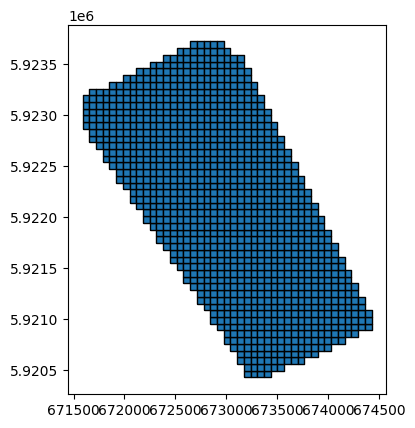

In [96]:
def generate_filtered_grid(gdf, n_grids):
    """
    Genera una grilla completa de cuadrados que cubre toda el área del GeoDataFrame de entrada y 
    luego filtra la grilla por las áreas donde el GeoDataFrame tiene valores válidos.

    Args:
    gdf (gpd.GeoDataFrame): GeoDataFrame de entrada.
    n_grids (int): Cantidad de cuadrículas a lo ancho.

    Returns:
    gpd.GeoDataFrame: GeoDataFrame con la grilla cuadrada filtrada.
    """
    # Calcular los límites del gdf y el tamaño de cada celda de la grilla
    minx, miny, maxx, maxy = gdf.total_bounds
    dx = maxx - minx
    dy = maxy - miny
    cell_size = max(dx, dy) / n_grids  # Asegura que la grilla cubra la mayor dimensión

    # Crear las celdas de la grilla
    grid_cells = []
    for i in range(n_grids):
        for j in range(n_grids):
            x1 = minx + i * cell_size
            y1 = miny + j * cell_size
            x2 = x1 + cell_size
            y2 = y1 + cell_size
            grid_cells.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))

    # Crear un GeoDataFrame para la grilla
    grid_gdf = gpd.GeoDataFrame(geometry=grid_cells)

    # Filtrar la grilla por la zona donde el gdf de entrada tiene valores válidos
    filtered_grid = grid_gdf[grid_gdf.intersects(gdf.unary_union)]

    return filtered_grid


# Supongamos que tienes un GeoDataFrame 'area_gdf' que define las esquinas del mapa
unit = generate_filtered_grid(mesh_gdf, n_grids=50)
unit.plot(edgecolor='black')
display(unit)

In [247]:
unit.to_file('./data/grid')

In [97]:
def max_height_per_grid_unit(grid_gdf, data_gdf):
    """
    Encuentra la altura máxima en cada cuadrícula de la grilla usando los datos de un segundo GeoDataFrame.

    Args:
    grid_gdf (gpd.GeoDataFrame): GeoDataFrame de la grilla.
    data_gdf (gpd.GeoDataFrame): GeoDataFrame con los datos de alturas.

    Returns:
    gpd.GeoDataFrame: GeoDataFrame de la grilla con la altura máxima en cada cuadrícula.
    """
    # Asegurarse de que los GeoDataFrames estén en el mismo sistema de coordenadas
    if grid_gdf.crs != data_gdf.crs:
        data_gdf = data_gdf.to_crs(grid_gdf.crs)

    # Inicializar una lista para almacenar las alturas máximas
    max_heights = []

    # Iterar sobre cada cuadrícula de la grilla
    for _, grid_cell in grid_gdf.iterrows():
        # Encontrar los datos que intersectan con la cuadrícula actual
        intersecting_data = data_gdf[data_gdf.intersects(grid_cell.geometry)]

        # Calcular la altura máxima dentro de esta cuadrícula, si hay datos disponibles
        max_height = intersecting_data['z'].max() if not intersecting_data.empty else None

        # Agregar la altura máxima a la lista
        max_heights.append(max_height)

    # Agregar la columna de alturas máximas al GeoDataFrame de la grilla
    grid_gdf['max_height'] = max_heights

    return grid_gdf

# Suponiendo que tienes un GeoDataFrame 'unit' para la grilla y otro 'mesh_gdf' con datos de alturas
grid_with_max_heights = max_height_per_grid_unit(unit, mesh_gdf)
grid_with_max_heights.head()


,geometry,max_height
37,"POLYGON ((671588.602 5922866.443, 671654.542 5...",10.000000
38,"POLYGON ((671588.602 5922932.384, 671654.542 5...",10.000000
39,"POLYGON ((671588.602 5922998.324, 671654.542 5...",12.073290
40,"POLYGON ((671588.602 5923064.265, 671654.542 5...",14.055653
41,"POLYGON ((671588.602 5923130.205, 671654.542 5...",15.148014


<Axes: >

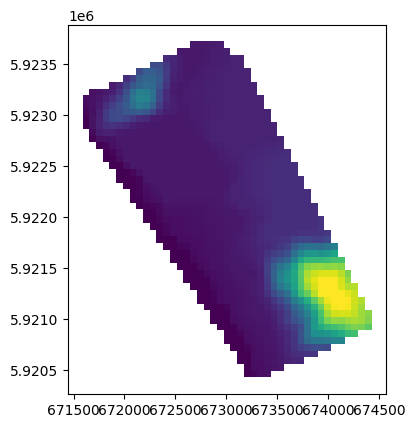

In [98]:
grid_with_max_heights.plot(column='max_height')

In [99]:
edificaciones_gdf.rename(columns={'Metros': 'Height'}, inplace=True)

In [100]:
mesh_gdf = mesh_gdf.set_crs(edificaciones_gdf.crs)

In [101]:
def calculate_terrain_stats_for_buildings(buildings_gdf, terrain_gdf):
    """
    Calcula los valores máximo, mínimo y promedio de las alturas del terreno para cada edificación.

    Args:
    buildings_gdf (gpd.GeoDataFrame): GeoDataFrame de las edificaciones.
    terrain_gdf (gpd.GeoDataFrame): GeoDataFrame con las alturas del terreno.

    Returns:
    gpd.GeoDataFrame: GeoDataFrame de las edificaciones con los valores estadísticos agregados.
    """
    # Asegurarse de que los GeoDataFrames estén en el mismo sistema de coordenadas
    if buildings_gdf.crs != terrain_gdf.crs:
        terrain_gdf = terrain_gdf.to_crs(buildings_gdf.crs)

    # Inicializar listas para almacenar los valores estadísticos
    max_heights, min_heights, mean_heights = [], [], []

    # Iterar sobre cada edificación
    for _, building in buildings_gdf.iterrows():
        # Encontrar los puntos del terreno que están dentro de la edificación
        within_building = terrain_gdf[terrain_gdf.within(building.geometry)]

        # Calcular estadísticas si hay puntos dentro de la edificación
        if not within_building.empty:
            max_heights.append(within_building['z'].max())
            min_heights.append(within_building['z'].min())
            mean_heights.append(within_building['z'].mean())
        else:
            max_heights.append(np.nan)
            min_heights.append(np.nan)
            mean_heights.append(np.nan)

    # Agregar las estadísticas al GeoDataFrame de las edificaciones
    buildings_gdf['max_terrain_height'] = max_heights
    buildings_gdf['min_terrain_height'] = min_heights
    buildings_gdf['mean_terrain_height'] = mean_heights

    return buildings_gdf

# Debes tener el GeoDataFrame 'edificaciones_gdf' y 'mesh_gdf' definidos
updated_buildings_gdf = calculate_terrain_stats_for_buildings(edificaciones_gdf, mesh_gdf)
updated_buildings_gdf.head()


,Pisos,Height,geometry,max_terrain_height,min_terrain_height,mean_terrain_height
0,1,2.3,"POLYGON Z ((672366.221 5923338.172 0.000, 6723...",38.704050,38.704050,38.704050
1,1,2.3,"POLYGON Z ((672901.158 5923351.030 0.000, 6728...",23.468452,23.370136,23.419329
2,5,11.5,"POLYGON Z ((672743.696 5923418.746 0.000, 6727...",20.406486,20.128131,20.273232
3,1,2.3,"POLYGON Z ((672933.595 5923299.034 0.000, 6729...",24.427803,24.346788,24.386397
4,2,4.6,"POLYGON Z ((672811.046 5923396.363 0.000, 6728...",21.624430,21.547010,21.585368


In [102]:
updated_buildings_gdf.dropna(subset=['max_terrain_height']).shape

(6438, 6)

In [105]:
edificaciones_gdf.shape

(6773, 6)

In [106]:
updated_buildings_gdf[updated_buildings_gdf['max_terrain_height'].isna()]

,Pisos,Height,geometry,max_terrain_height,min_terrain_height,mean_terrain_height
41,1,2.3,"POLYGON Z ((672253.924 5923473.052 0.000, 6722...",NaN,NaN,NaN
45,1,2.3,"POLYGON Z ((672699.809 5923725.096 0.000, 6726...",NaN,NaN,NaN
56,1,2.3,"POLYGON Z ((672230.075 5923471.317 0.000, 6722...",NaN,NaN,NaN
57,1,2.3,"POLYGON Z ((672243.551 5923529.000 0.000, 6722...",NaN,NaN,NaN
61,1,2.3,"POLYGON Z ((672256.140 5923482.067 0.000, 6722...",NaN,NaN,NaN
...,...,...,...,...,...,...
6761,2,4.6,"POLYGON Z ((673825.798 5920574.220 0.000, 6738...",NaN,NaN,NaN
6762,1,2.3,"POLYGON Z ((673828.580 5920590.181 0.000, 6738...",NaN,NaN,NaN
6763,1,2.3,"POLYGON Z ((674051.168 5920689.357 0.000, 6740...",NaN,NaN,NaN
6764,2,4.6,"POLYGON Z ((674061.805 5920689.719 0.000, 6740...",NaN,NaN,NaN


In [248]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Preparar los datos
X = mesh_gdf[['x', 'y']]  # Características: coordenadas x, y
y = mesh_gdf['z']        # Variable objetivo: altura z

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo K-NN
knn_regressor = KNeighborsRegressor(n_neighbors=5)  # Puedes ajustar el número de vecinos
knn_regressor.fit(X_train, y_train)

import joblib

# Guardar el modelo en un archivo
model_filename = 'knn_model.pkl'
joblib.dump(knn_regressor, model_filename)

# Predecir y evaluar el modelo
y_pred = knn_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("RMSE: ", rmse)

RMSE:  0.10982504142180861


In [110]:
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error

# Continuación del código anterior después de predecir con el modelo K-NN

# Calcular MAE (Error Absoluto Medio)
mae = mean_absolute_error(y_test, y_pred)

# Calcular R^2 (Coeficiente de Determinación)
r2 = r2_score(y_test, y_pred)

# Calcular MedAE (Error Absoluto Mediano)
medae = median_absolute_error(y_test, y_pred)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R^2: ", r2)
print("MedAE: ", medae)

RMSE:  0.10982504142180861
MAE:  0.0490990735967111
R^2:  0.9999885840149854
MedAE:  0.00893870841536426


In [140]:
centroids_in = updated_buildings_gdf.loc[updated_buildings_gdf['max_terrain_height'].isna(), 'geometry'].centroid

data = {
    'x': centroids_in.x.values,
    'y': centroids_in.y.values,
}

data = pd.DataFrame.from_dict(data)
data['max_terrain_height_pred'] = knn_regressor.predict(data)
data = convert_mesh_to_gdf(data)

In [141]:
updated_buildings_gdf['x'] = updated_buildings_gdf['geometry'].centroid.x
updated_buildings_gdf['y'] = updated_buildings_gdf['geometry'].centroid.y

In [156]:
mesh_gdf

,x,y,z,geometry
0,671588.601904,5.923132e+06,10.005854,POINT (671588.602 5923131.726)
1,671588.601904,5.923135e+06,10.097122,POINT (671588.602 5923135.033)
2,671588.601904,5.923138e+06,10.188390,POINT (671588.602 5923138.340)
3,671591.437435,5.923122e+06,10.000000,POINT (671591.437 5923121.806)
4,671591.437435,5.923125e+06,10.012000,POINT (671591.437 5923125.113)
...,...,...,...,...
485448,674412.790709,5.920969e+06,125.647119,POINT (674412.791 5920968.985)
485449,674412.790709,5.920972e+06,126.009212,POINT (674412.791 5920972.292)
485450,674412.790709,5.920976e+06,126.363188,POINT (674412.791 5920975.599)
485451,674415.626239,5.920966e+06,125.100618,POINT (674415.626 5920965.678)


In [158]:
merge_gdf = pd.merge(updated_buildings_gdf, data.drop(columns=['geometry']), how='outer', on=['x','y'])

[merge_gdf[col].fillna(0, inplace=True) for col in ['max_terrain_height', 'max_terrain_height_pred']];

merge_gdf['baseline_height'] = merge_gdf[['max_terrain_height', 'max_terrain_height_pred']].sum(axis=1)
merge_gdf.rename(columns={'Height': 'building_height'}, inplace=True)

merge_cols = ['building_height', 'baseline_height', 'geometry']

merge_gdf = merge_gdf[merge_cols]
merge_gdf['z'] = merge_gdf[['building_height', 'baseline_height']].sum(axis=1)

<Axes: >

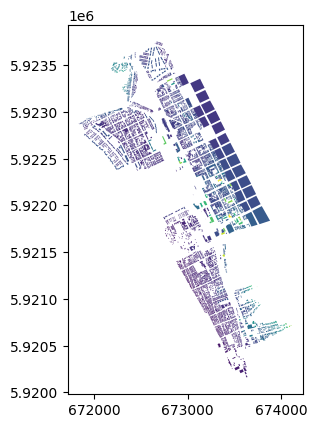

In [171]:
def calculate_max_height_for_grid(grid_gdf, merge_gdf, mesh_gdf):
    """
    Calcula la altura máxima en cada cuadrícula del grid, utilizando dos GeoDataFrames:
    uno con la altura de edificaciones sobre el terreno y otro con la altura del terreno.

    Args:
    grid_gdf (gpd.GeoDataFrame): GeoDataFrame con las cuadrículas.
    merge_gdf (gpd.GeoDataFrame): GeoDataFrame con alturas de edificaciones sobre el terreno.
    mesh_gdf (gpd.GeoDataFrame): GeoDataFrame con alturas del terreno.

    Returns:
    gpd.GeoDataFrame: GeoDataFrame de las cuadrículas con la altura máxima en cada una.
    """
    max_heights = []

    # Asegurarse de que todos los GeoDataFrames estén en el mismo sistema de coordenadas
    if grid_gdf.crs != merge_gdf.crs:
        merge_gdf = merge_gdf.to_crs(grid_gdf.crs)

    if grid_gdf.crs != mesh_gdf.crs:
        mesh_gdf = mesh_gdf.to_crs(grid_gdf.crs)

    # Iterar sobre cada cuadrícula en el grid
    for _, grid_cell in grid_gdf.iterrows():
        # Encontrar las edificaciones que intersectan con la cuadrícula
        intersecting_buildings = merge_gdf[merge_gdf.intersects(grid_cell.geometry)]

        # Encontrar los puntos del terreno que están dentro de la cuadrícula
        intersecting_terrain = mesh_gdf[mesh_gdf.within(grid_cell.geometry)]

        # Determinar la altura máxima
        if not intersecting_buildings.empty:
            # Usar la altura de las edificaciones si hay alguna en la cuadrícula
            max_height = intersecting_buildings['z'].max()
        elif not intersecting_terrain.empty:
            # Usar la altura del terreno si no hay edificaciones
            max_height = intersecting_terrain['z'].max()
        else:
            # Si no hay ni edificaciones ni terreno, asignar NaN
            max_height = np.nan

        max_heights.append(max_height)

    # Agregar la columna de alturas máximas al GeoDataFrame del grid
    grid_gdf['max_height'] = max_heights

    return grid_gdf

# Uso de la función
# Suponiendo que tienes los GeoDataFrames 'grid_gdf', 'merge_gdf' y 'mesh_gdf' definidos
# unit = unit.set_crs(edificaciones_gdf.crs)
# merge_gdf = merge_gdf.set_crs(edificaciones_gdf.crs)
# mesh_gdf = mesh_gdf.set_crs(edificaciones_gdf.crs)

grid_with_max_heights = calculate_max_height_for_grid(unit, merge_gdf, mesh_gdf)
grid_with_max_heights.head()



,geometry,max_height
37,"POLYGON ((671588.602 5922866.443, 671654.542 5...",10.000000
38,"POLYGON ((671588.602 5922932.384, 671654.542 5...",10.000000
39,"POLYGON ((671588.602 5922998.324, 671654.542 5...",12.073290
40,"POLYGON ((671588.602 5923064.265, 671654.542 5...",14.055653
41,"POLYGON ((671588.602 5923130.205, 671654.542 5...",15.148014


<Axes: >

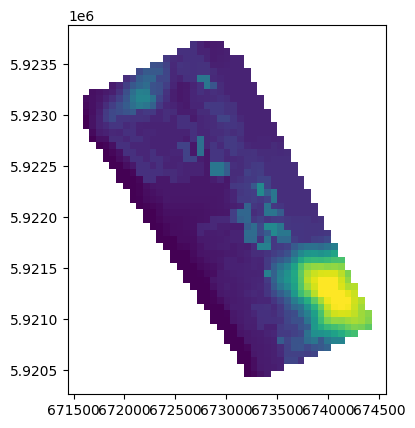

In [173]:
grid_with_max_heights.plot(column='max_height')

In [238]:
def map_values_to_range(values, vmin, vmax):
    """
    Mapea una lista de valores a un rango de valores enteros entre vmin y vmax.

    Args:
    values (list): Lista de valores a mapear.
    vmin (int): Valor mínimo del rango objetivo.
    vmax (int): Valor máximo del rango objetivo.

    Returns:
    list: Lista de valores mapeados al rango especificado.
    """
    # Convertir la lista a un array de numpy para facilitar el cálculo
    values_array = np.array(values)

    # Normalizar los valores para que estén entre 0 y 1
    normalized = (values_array - np.min(values_array)) / (np.max(values_array) - np.min(values_array))

    # Escalar los valores normalizados al rango deseado y convertirlos a enteros
    scaled_values = (normalized * (vmax - vmin) + vmin).astype(int)

    return scaled_values.tolist()

# Ejemplo de uso
values = grid_with_max_heights['max_height']
vmin, vmax = 0, 36
grid_with_max_heights['LEGO'] = map_values_to_range(values, vmin, vmax)

<Axes: >

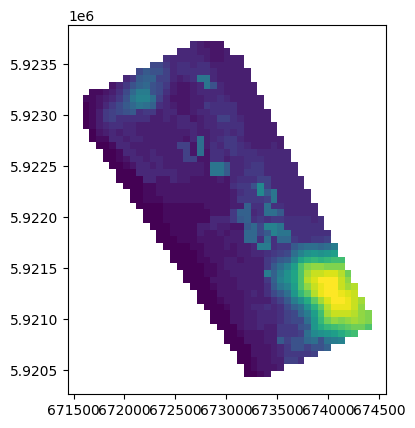

In [239]:
grid_with_max_heights.plot(column='LEGO')

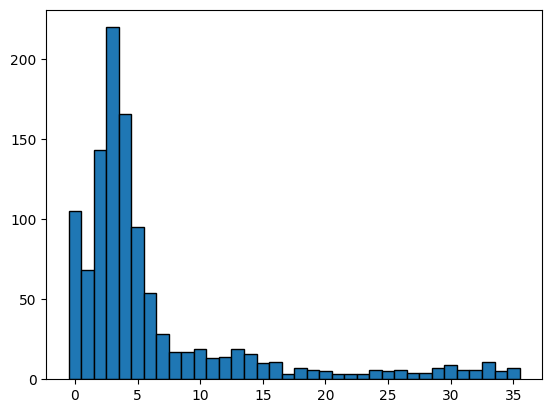

In [240]:
grid_with_max_heights['LEGO'].hist(bins=np.arange(vmin-0.5, vmax+0.5), edgecolor='black')
plt.grid(False)

In [241]:
grid_gdf = grid_with_max_heights.copy()

In [242]:
from shapely.geometry import Polygon, MultiPolygon
import pyvista as pv

def create_prism_mesh_and_sides(input_polygon, height, h0=0):
    # Verificar si es un MultiPolygon y convertirlo a una lista de polígonos si es necesario
    if isinstance(input_polygon, MultiPolygon):
        polygons = list(input_polygon.geoms)
    elif isinstance(input_polygon, Polygon):
        polygons = [input_polygon]
    else:
        raise ValueError("Input debe ser un Polygon o MultiPolygon")

    # Inicializar una lista para almacenar los resultados de cada polígono
    result_meshes = []

    # Iterar sobre los polígonos
    for polygon in polygons:
        # Extraer los puntos x, y del polígono
        x, y = polygon.exterior.coords.xy

        # Crear los puntos para las caras superiores e inferiores
        top_points = [(xi, yi, height + h0) for xi, yi in zip(x, y)]
        bottom_points = [(xi, yi, h0) for xi, yi in zip(x, y)]

        # Combinar los puntos en una lista
        points = bottom_points[:-1] + top_points[:-1]

        # Calcular el número de puntos en el polígono
        num_points = len(polygon.exterior.coords) - 1

        # Crear las caras de la malla
        faces = [
            [num_points] + list(range(num_points)),             # Cara inferior
            [num_points] + list(range(num_points, 2 * num_points))  # Cara superior
        ]

        # Crear la malla principal del prisma
        main_mesh = pv.PolyData(points, faces)
        main_mesh.texture_map_to_plane(inplace=True)

        # Lista para guardar las mallas de las caras laterales
        side_meshes = []

        # Crear mallas para cada cara lateral
        for i in range(num_points):
            side_points = [
                points[i], points[(i + 1) % num_points],
                points[(i + 1) % num_points + num_points], points[i + num_points]
            ]
            side_faces = [[4, 0, 1, 2, 3]]  # Un cuadrilátero por cada cara lateral
            side_mesh = pv.PolyData(side_points, side_faces)

            # Asignar coordenadas de textura
            side_mesh.texture_map_to_plane(inplace=True)

            side_meshes.append(side_mesh)

        # Agregar el resultado de este polígono a la lista de resultados
        result_meshes.append((main_mesh, side_meshes))

    return result_meshes

In [243]:
grid_gdf

,geometry,max_height,LEGO
37,"POLYGON ((671588.602 5922866.443, 671654.542 5...",10.000000,0
38,"POLYGON ((671588.602 5922932.384, 671654.542 5...",10.000000,0
39,"POLYGON ((671588.602 5922998.324, 671654.542 5...",12.073290,0
40,"POLYGON ((671588.602 5923064.265, 671654.542 5...",14.055653,0
41,"POLYGON ((671588.602 5923130.205, 671654.542 5...",15.148014,1
...,...,...,...
2060,"POLYGON ((674292.160 5921086.051, 674358.101 5...",143.056880,30
2061,"POLYGON ((674292.160 5921151.992, 674358.101 5...",146.515402,31
2107,"POLYGON ((674358.101 5920888.230, 674424.041 5...",126.193710,26
2108,"POLYGON ((674358.101 5920954.170, 674424.041 5...",135.707341,29


In [244]:
meshes = []
[meshes.append(create_prism_mesh_and_sides(row['geometry'], row['max_height'])) for index, row in grid_gdf.iterrows()];

In [245]:
plotter = pv.Plotter()

for resultados in meshes:
    for resultado in resultados:
        plotter.add_mesh(resultado[0])
        for sample in resultado[1]:
            plotter.add_mesh(sample)

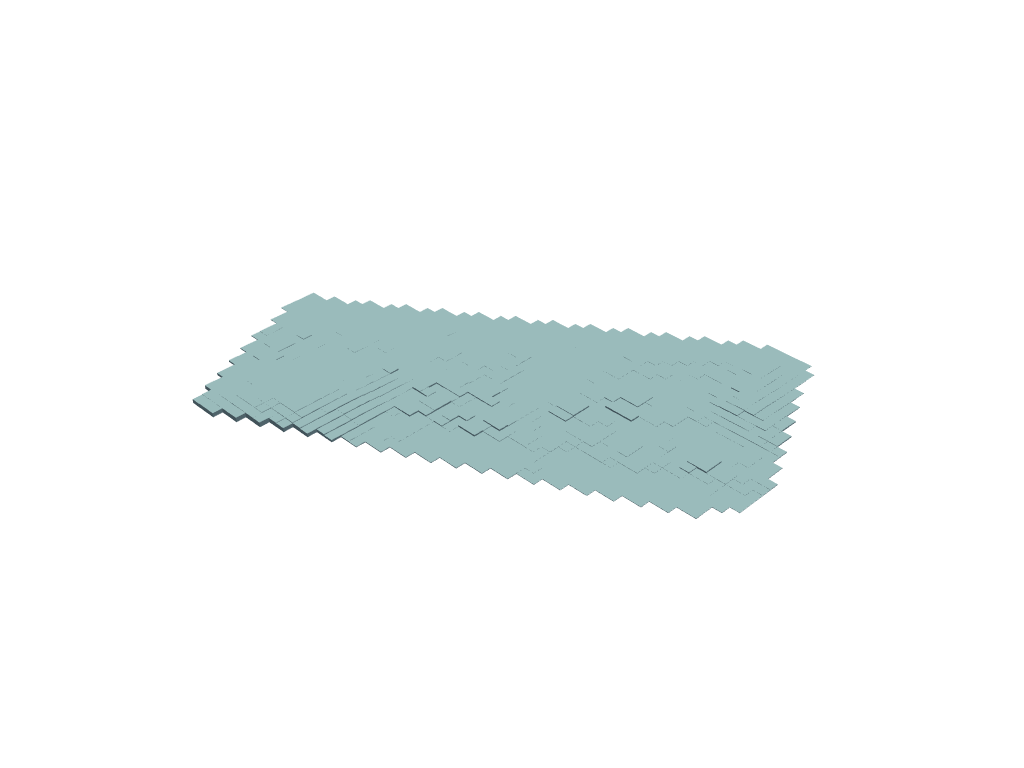

In [246]:
plotter.show()

/home/diego/Proyectos/3d/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


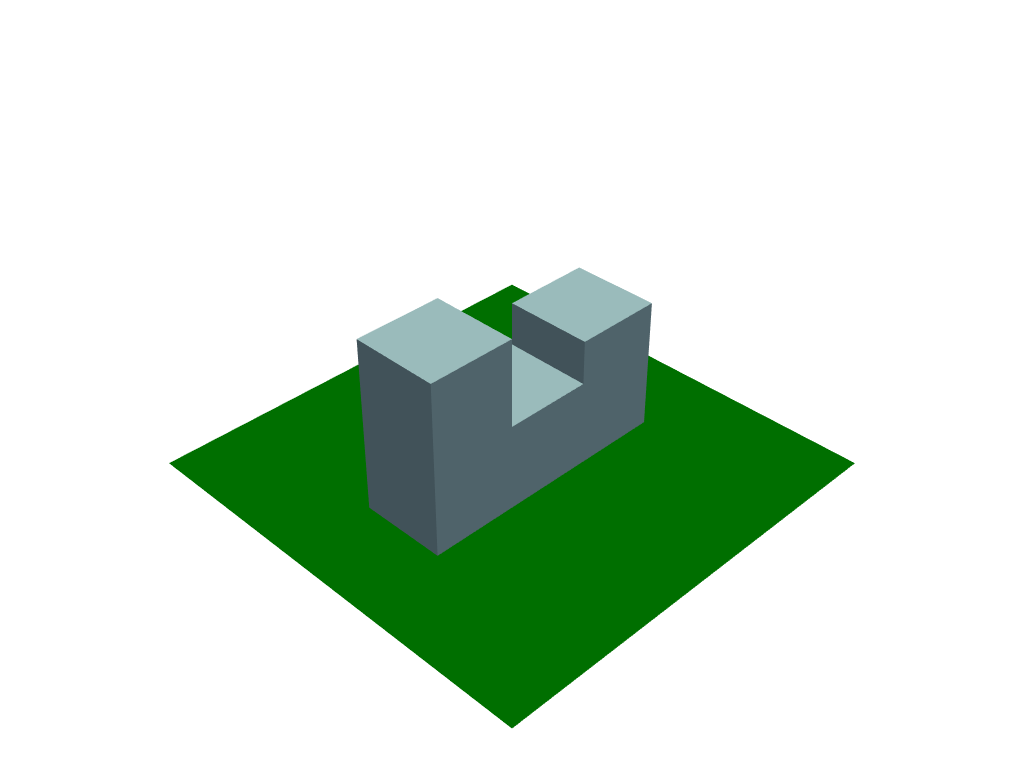

In [6]:
import pyvista as pv

# Crear el plotter
plotter = pv.Plotter()

# Crear tres cajas con alturas diferentes
cajas = {
    'caja1': pv.Box(bounds=(-1, 1, -1, 1, 0, 2)),
    'caja2': pv.Box(bounds=(-3, -1, -1, 1, 0, 3)),
    'caja3': pv.Box(bounds=(1, 3, -1, 1, 0, 4))
}

# Añadir las cajas al plotter
for id, caja in cajas.items():
    plotter.add_mesh(caja, name=id)

# Crear un plano que actúe como el piso
piso = pv.Plane(center=(0, 0, 0), direction=(0, 0, 1), i_size=10, j_size=10)
plotter.add_mesh(piso, color='green')

# Función para mover un objeto en el eje Z
def move_object_z(id, delta_z):
    caja = cajas[id].copy()  # Crear una copia de la malla
    caja.translate((0, 0, delta_z))
    plotter.remove_actor(plotter.actors[id])  # Remover el actor anterior
    plotter.add_mesh(caja, name=id)  # Añadir la malla actualizada

# Mover las cajas hacia arriba y luego hacia abajo
for _ in range(10):  # Subir 10 unidades
    for id in cajas:
        move_object_z(id, 1)
    plotter.render()

for _ in range(10):  # Bajar 10 unidades
    for id in cajas:
        move_object_z(id, -1)
    plotter.render()

plotter.show()


In [1]:
import geopandas as gpd

In [2]:
gdf = gpd.read_file('./data/manzanas_hab/Manzanas base')

In [6]:
gdf.columns

Index(['OBJECTID', 'REGION', 'NOM_REGION', 'PROVINCIA', 'NOM_PROVIN', 'COMUNA',
       'NOM_COMUNA', 'MANZENT_I', 'Number_res', 'Number_hou', 'ID_PLACA',
       'DISTRITO', 'LOC_ZON', 'ENT_MAN', 'CATEGORIA', 'NOM_CATEGO',
       'TOTAL_PERS', 'TOTAL_VIVI', 'ha', 'hab_ha', 'geometry'],
      dtype='object')

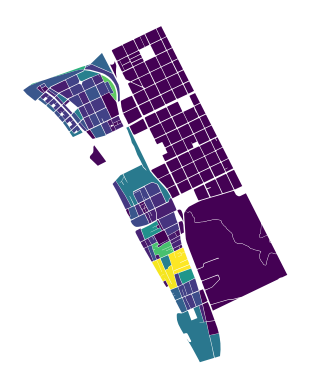

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gdf.plot(column='Number_res', ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('manzanas.png')